# Diffusion Matching Sandbox

This notebook will serve as a testing venue for matching an Epstein-Plesset-like model of bubble growth in a supersaturated liquid with a concentration-dependent diffusion model of CO2 concentration in sheath flow.

The basis for the diffusion model will come from `20200905_diffn_in_out_vs_Qi.ipynb` and the basis for the bubble growth model will come from the model used in `analytics.fit_growth_to_pt()`, as in `20201010_v360_co2_c5_11184...ipynb`.

In [1]:
# SETUP

# adds custom libraries to path
import sys
sys.path.append('../libs/')

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt

# imports custom libraries
import polyco2
import diffn
import flow
import plot.diffn as pltd
import bubble
import bubbleflow

from importlib import reload


# flow parameters for experiments in 20200905_80bar folder
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken [m]
d = 0.096

# grid parameters
R_o = 150E-6 # outer radius [m]
N = 25 # number of grid spacings 

# diffusion model parameters 
dt = 50E-6 # time step [s]
dcdt_fn = diffn.calc_dcdt_cyl

def f_bc_specs(c_s):
    """
    c_s is saturation concentration [kg/m^3].
    
    Fixes concentration at inner wall of capillary to 0.
    Fixed concentration at bubble surface (saturation concentration).
    """
    return [(diffn.dirichlet, 0, c_s), (diffn.dirichlet, -1, 0)]

dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = '1k3f_22c.csv'

# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

# CONVERSIONS
m_2_um = 1E6
m_2_mm = 1E3
s_2_ms = 1E3
uLmin_2_m3s = 1/60E9

## Solve Diffusion with Fixed Bubble Radius

We first consider the problem where the bubble has a fixed radius, such that the diffusion is governed by Fick's law with fixed concentration at the two boundaries.

In [7]:
# fixes radius of bubble [m]
R_bubble = 5E-6
# creates grid of radii from bubble radius to inner wall of capillary [m]
r_arr = np.linspace(R_bubble, R_o, N+1)

# computes inner stream radius [m] and velocity [m/s]
_, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)

# creates initial concentration profile [kg CO2 / m^3 polyol-CO2]
c_0 = np.zeros([N+1])
c_s = polyco2.calc_c_s(p_s, polyol_data_file)
c_0[r_arr <= R_i] = c_s
dc = c_s*dc_c_s_frac
t_f = d/v

0.1


### Compute Diffusion Profile Downstream

This is an odd and unphysical situation that assumes that the bubble will emerge at the beginning of the channel and maintain the same radius and saturation concentration throughout.

In [22]:
t, c = diffn.go(dt, t_f, R_bubble, R_o, N, c_0, dcdt_fn, f_bc_specs(0.2*c_s),
        eta_i, eta_o, d, L, Q_i, Q_o, p_s, dc_c_s_frac, polyol_data_file)

#### Plot Results

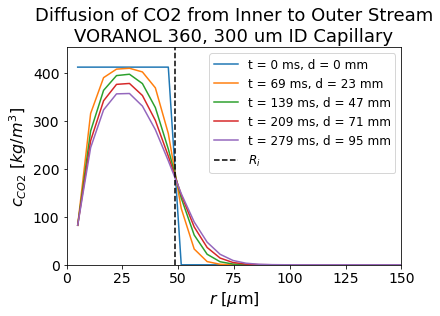

In [23]:
n_plot = 4
_ = pltd.sheath(t, r_arr, c, R_i, R_o, v, c_s, n_plot)

While slow, the bulk diffusion model still successfully modeled diffusion with concentration fixed at a given bubble radius. Next, we will adjust that bubble radius according to the mass of CO2 that diffuses into the bubble.

### Run Flow and Growth Simultaneously but Without Interaction

This will be a test of the way that I decomposed the functions.

In [5]:
import bubbleflow

reload(bubbleflow)

dt_sheath = 50E-6 # [s]
dt = 1E-12 # [s]
t_nuc = d/v # [s]
R_nuc = 5E-6 # [m]
d = L
eos_co2_file = 'eos_co2_22-0C.csv'
bc_specs_list = [(diffn.neumann, 0, 1, 0, r_arr), (diffn.dirichlet, -1, 0)]



0.3435867399140641


In [17]:
reload(diffn)
reload(bubbleflow)

t, c, t_bub, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, R_i, v = bubbleflow.grow(dt_sheath, dt, dcdt_fn, R_o, N, eta_i, eta_o, d, L, Q_i, Q_o, p_s,
                                         dc_c_s_frac, t_nuc, R_nuc, polyol_data_file, eos_co2_file, bc_specs_list)

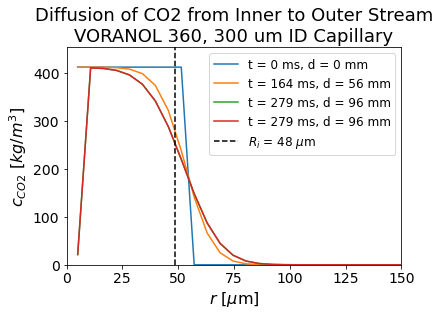

In [12]:
reload(pltd)
n_plot = 4
_ = pltd.sheath(t, r_arr, c, R_i, R_o, v, c_s, n_plot)

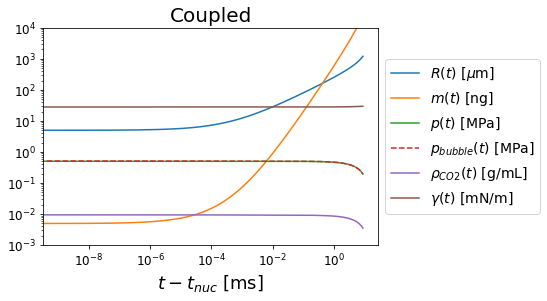

In [15]:
import plot.bubble as pltb

props_list = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_bub, t_nuc, props_list, x_log=True, title='Coupled')

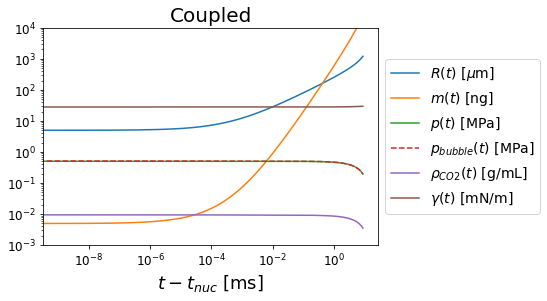

In [18]:
import plot.bubble as pltb

props_list = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_bub, t_nuc, props_list, x_log=True, title='Coupled')

### Compare Fully Numerical and Epstein-Plesset with Numerical Time-stepping

In [159]:
import bubble
reload(diffn)
reload(bubble)
reload(bubbleflow)

p_atm = 101.3E3
uLmin_2_m3s = 1/60E9
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s,
                                    Q_o*uLmin_2_m3s, R_o, SI=True)
p_in = p_atm - dp
R_max = 100E-6
N = 400

dt = 1E-12 # [s]
dr = R_max/N # [m]
dt_max = 0.5*(dr**2/D) # keeps time step below half of diffusion time scale

t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, r_arr = bubbleflow.numerical_eps_pless_fix_D(dt, t_nuc, p_s, R_nuc, L, p_in, v, R_max, N,
                                         polyol_data_file, eos_co2_file, dt_max=dt_max)

TypeError: unsupported operand type(s) for /: 'float' and 'list'

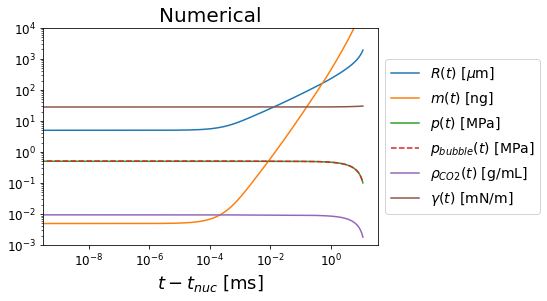

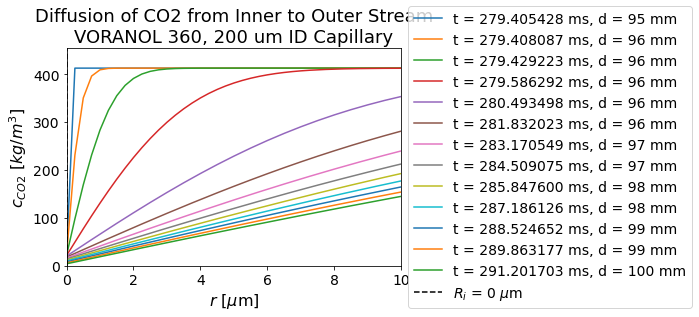

In [127]:
import plot.bubble as pltb
import plot.genl as pltg

props_list_num = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_num, x_log=True, title='Numerical')

reload(pltd)
n_plot = 12
ax = pltd.sheath(t_flow, r_arr, c, 0, R_max, v, c_bulk, n_plot)
# ax.set_xscale('log')
ax.set_xlim([0, 10])

# plots legend outside box
pltg.legend(ax)

**Note that when plotting on log(r) scale, the line from r = 0 to the first finite value of r will look horizontal because r = 0 is infinitely far away on a log scale.**


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


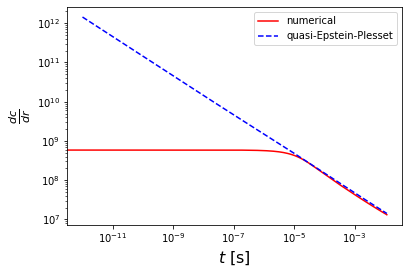

In [91]:
# uses 2nd order Taylor scheme
dcdr_num = [(-3*c[i][0]+4*c[i][1]-c[i][2])/(r_arr[2]-r_arr[0]) for i in range(len(c))]

dcdr_qeps = (np.asarray(c_bulk) - np.asarray(c_bub))*(1/np.asarray(R) + 1/np.sqrt(np.pi*D*(np.asarray(t_num)-t_nuc)))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.asarray(t_num) - t_num[0], dcdr_num, 'r-', label='numerical')
ax.plot(np.asarray(t_num) - t_num[0], dcdr_qeps, 'b--', label='quasi-Epstein-Plesset')

ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$\frac{dc}{dr}$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()

The concentration gradient is much higher for the numerical solution than would be calculated by the Epstein-Plesset model.

##### Epstein-Plesset Model

In [93]:
reload(bubble)
t_eps, m, D, p, p_bub, if_tension, c_s, c_bulk, R, rho_co2 = bubble.grow(dt, t_nuc, p_s, R_nuc, p_atm, L, p_in, v,
                     polyol_data_file, eos_co2_file)

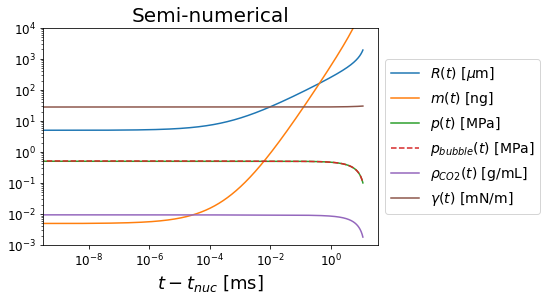

In [94]:
props_list_eps = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_eps, t_nuc, props_list_eps, x_log=True, title='Semi-numerical')

Compare the difference between numerical Epstein-Plesset and analytical.

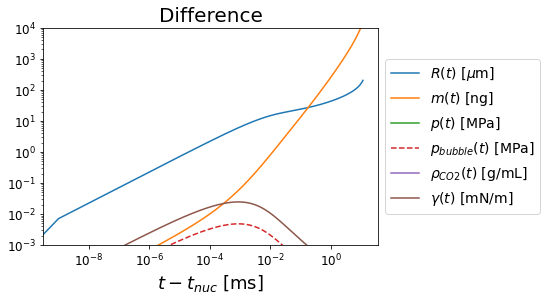

In [95]:
props_list_diff = [np.abs(np.interp(t_eps, t_num, np.asarray(props_list_num[i])) - np.asarray(props_list_eps[i])) for i in range(len(props_list_num))]
ax = pltb.all_props(t_eps, t_nuc, props_list_diff, x_log=True, title='Difference')

Difference in radius at the end is about 200 um. Seems negligibly affected by N (compared N = 50 and N = 200 @ R_max = 100 um).

For R_max = 200 um (N = 400 to have same grid spacing), difference in radius is still about 200 um at the end.

The diffusivity D and bulk concentration c_bulk are identical for both cases, as expected.

#### Compare Difference in Concentration Gradient at Bubble Interface

Plotting the analytical result for the concentration profile in the bulk is challenging due to improper integrals without an explicit form. Instead, I will plot the concentration gradient at the bubble interface, which has an explicit form in the Epstein-Plesset solution,

\begin{align}
\left( \frac{\partial c}{\partial r} \right)_R &= (c_B - c_s) \left[\frac{1}{R} + \frac{1}{\sqrt{\pi D t}} \right] \\
\end{align}

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


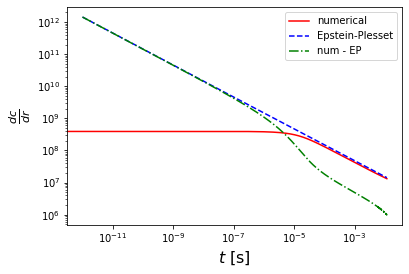

In [96]:
dr = R_max/N
dcdr_num = [(c[i][1]-c[i][0])/dr for i in range(len(c))]

dcdr_eps = (np.asarray(c_bulk) - np.asarray(c_s))*(1/np.asarray(R) + 1/np.sqrt(np.pi*D*(np.asarray(t_eps)-t_nuc)))

# difference
dcdr_diff = np.abs(np.asarray(dcdr_num) - np.interp(t_num, t_eps, dcdr_eps))

# plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.asarray(t_num) - t_num[0], dcdr_num, 'r-', label='numerical')
ax.plot(np.asarray(t_eps) - t_eps[0], dcdr_eps, 'b--', label='Epstein-Plesset')
ax.plot(np.asarray(t_num) - t_num[0], dcdr_diff, 'g-.', label='num - EP')

ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$\frac{dc}{dr}$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()

The difference in concentration gradients is very large. Perhaps enforcing the boundary condition before calculate the new concentration would increase the concentration gradient sufficiently.


Let me check that the bubble/saturation concentrations are the same (these are determined by the pressure in the channel, which is independent of the bubble growth scheme).

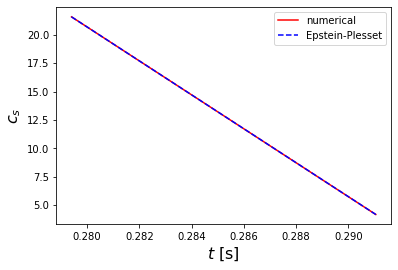

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.asarray(t_num), c_bub, 'r-', label='numerical')
ax.plot(np.asarray(t_eps), c_s, 'b--', label='Epstein-Plesset')

ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$c_s$', fontsize=16)

plt.legend()

### Try Computing Diffusion Using Transform from Epstein-Plesset Paper (1950)

$u = c/r$

In [104]:
reload(diffn)
reload(bubble)
reload(bubbleflow)

t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, r_arr = bubbleflow.numerical_eps_pless_fix_D(dt, t_nuc, p_s, R_nuc, L, p_in, v, R_max, N,
                     polyol_data_file, eos_co2_file, dcdt_fn=diffn.calc_dcdt_sph_fix_D_transf)

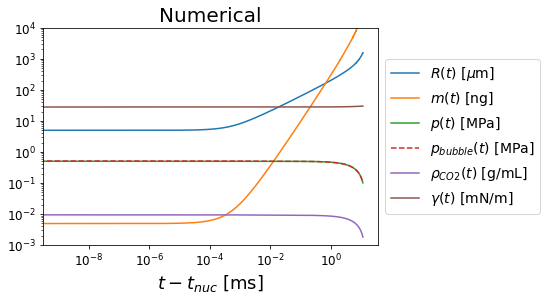

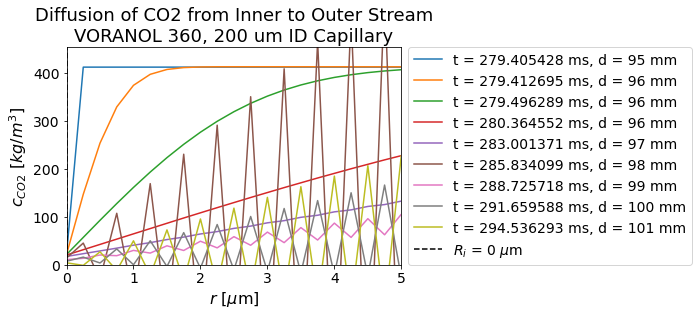

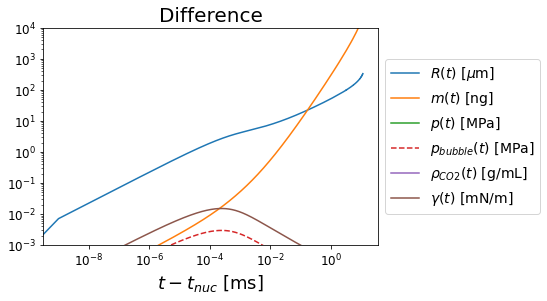

In [108]:
props_list_num = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_num, x_log=True, title='Numerical')

reload(pltd)
n_plot = 8
ax = pltd.sheath(t_flow, r_arr, c, 0, R_max, v, c_bulk, n_plot)
pltg.legend(ax)
ax.set_xlim([0, 5])

props_list_diff = [np.abs(np.interp(t_eps, t_num, np.asarray(props_list_num[i])) - np.asarray(props_list_eps[i])) for i in range(len(props_list_num))]
ax = pltb.all_props(t_eps, t_nuc, props_list_diff, x_log=True, title='Difference')

This transform only seems to increase the discrepancy in radius to over 300 um.

## Incorporate Concentration-dependence of Diffusivity

We approximate VORANOL 360 as 1k3f and assume a linear model of $D(c) = a c + b$.

In [186]:
import bubble
reload(diffn)
reload(bubble)
reload(bubbleflow)

p_atm = 101.3E3
uLmin_2_m3s = 1/60E9
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s,
                                    Q_o*uLmin_2_m3s, R_o, SI=True)
p_in = p_atm - dp
R_max = 100E-6
N = 100

dt = 1E-12 # [s]
dr = R_max/N # [m]
D_max = 3E-9
dt_max = 0.5*(dr**2/D_max) # keeps time step below half of diffusion time scale

t_flow1, c1, t_num1, m1, D, p1, p_bub1, if_tension1, \
c_bub, c_bulk, R1, rho_co21, v, r_arr = bubbleflow.numerical_eps_pless_fix_D(dt, t_nuc, p_s, R_nuc, L, p_in, v, R_max, N,
                                         polyol_data_file, eos_co2_file, dt_max=dt_max)

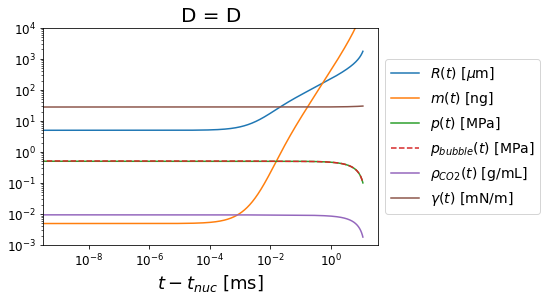

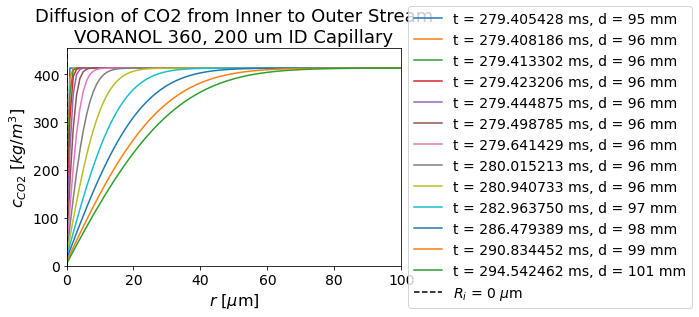

In [189]:
import plot.bubble as pltb
import plot.genl as pltg

props_list1 = (R1, m1, p1, p_bub1, rho_co21, if_tension1)
ax = pltb.all_props(t_num1, t_nuc, props_list1, x_log=True, title='D = D')

reload(pltd)
n_plot = 12
ax = pltd.sheath(t_flow1, r_arr, c1, 0, R_max, v, c_bulk, n_plot)
# ax.set_xscale('log')
# ax.set_xlim([0, 10])

# plots legend outside box
pltg.legend(ax)

In [190]:
D

2.3497250000000002e-08

In [191]:
def fixed_D(a, b):
    """Fixed diffusivity for comparison to numerical_eps_pless_fix_D()"""
    return 2.3497250000000002e-08

t_flow2, c2, t_num2, m2, D, p2, p_bub2, if_tension2, \
c_bub, c_bulk, R2, rho_co22, v, r_arr = bubbleflow.numerical_eps_pless_vary_D(dt, t_nuc, p_s, R_nuc, L, p_in, v, R_max, N,
                                                                             polyol_data_file, eos_co2_file, dc_c_s_frac,
                                                                           D_fn=fixed_D)

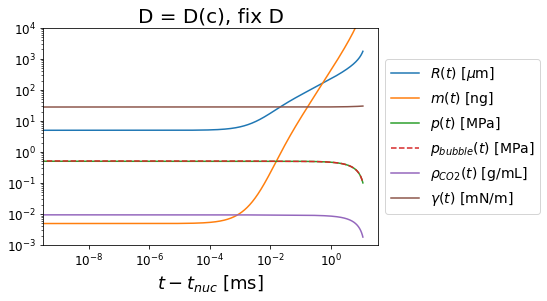

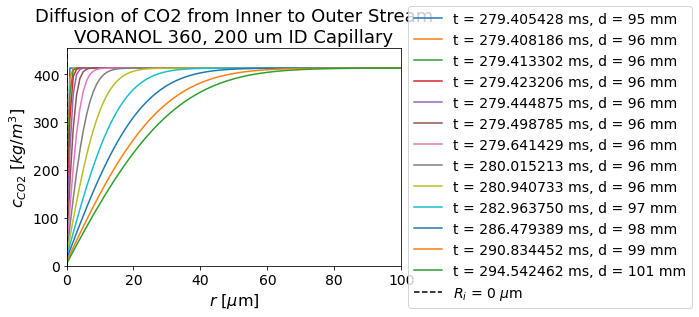

In [192]:
import plot.bubble as pltb
import plot.genl as pltg

props_list2 = (R2, m2, p2, p_bub2, rho_co22, if_tension2)
ax = pltb.all_props(t_num2, t_nuc, props_list2, x_log=True, title='D = D(c), fix D')

reload(pltd)
n_plot = 12
ax = pltd.sheath(t_flow2, r_arr, c2, 0, R_max, v, c_bulk, n_plot)
# ax.set_xscale('log')
# ax.set_xlim([0, 10])

# plots legend outside box
pltg.legend(ax)

../libs\plot\bubble.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.plot(t, np.array(rho_co2)*kgm3_2_gmL, label=r'$\rho_{CO2}(t)$ [g/mL]')


(0.0, 1e-06)

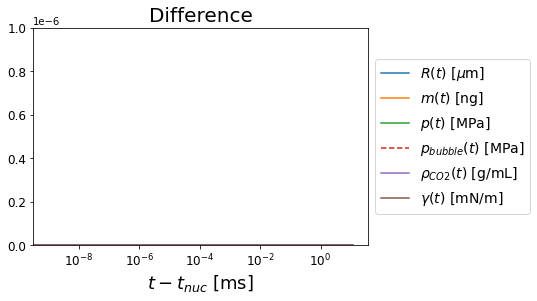

In [195]:
props_list_diff = [np.abs(np.asarray(props_list2[i]) - np.asarray(props_list1[i])) for i in range(len(props_list1))]
ax = pltb.all_props(t_num1, t_nuc, props_list_diff, x_log=True, title='Difference')
ax.set_yscale('linear')
ax.set_ylim([0, 1E-6])

Great! We have agreement between the method that varies D as a function of c and the previuos method with fixed D. Now I can feel confident that I am accurately computing the diffusion into the bubble.